In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
import lightgbm as lgb

In [2]:
df = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
df

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB
None
          Unnamed: 0       duration      days_left          price
count  300153.000000  300153.000000  300153.000000  300153.000000
mean   150076.000

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


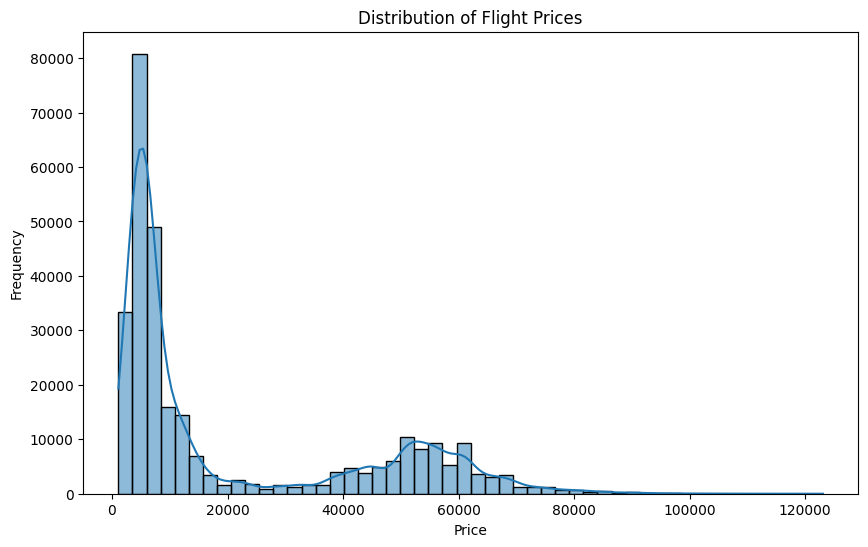

In [4]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'],bins=50,kde=True)
plt.title("Distribution of Flight Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

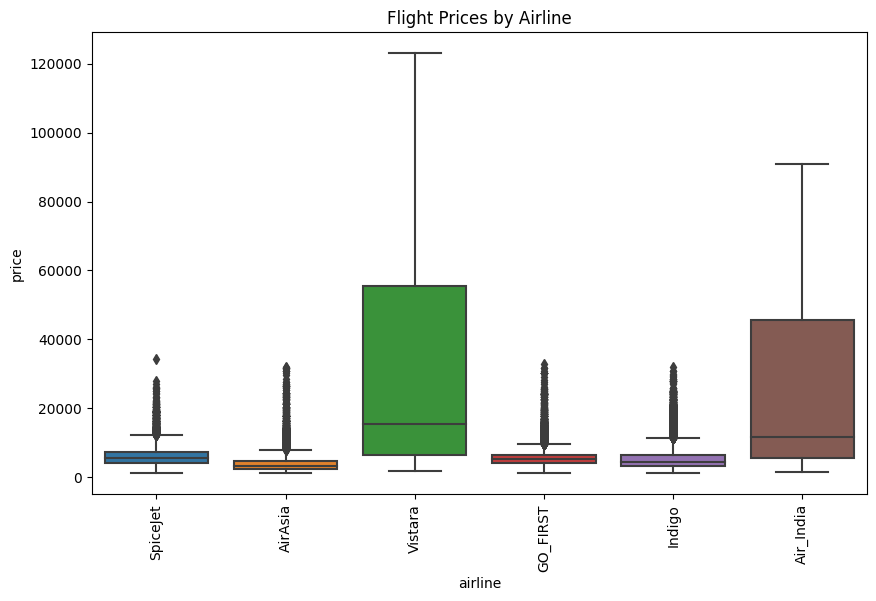

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='airline', y='price', data=df)
plt.title('Flight Prices by Airline')
plt.xticks(rotation=90)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x1000 with 0 Axes>

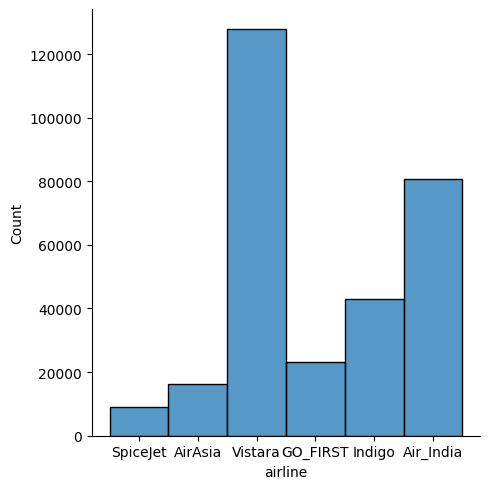

In [6]:
plt.figure(figsize=(10, 10))
sns.displot(df, x="airline")
plt.show()

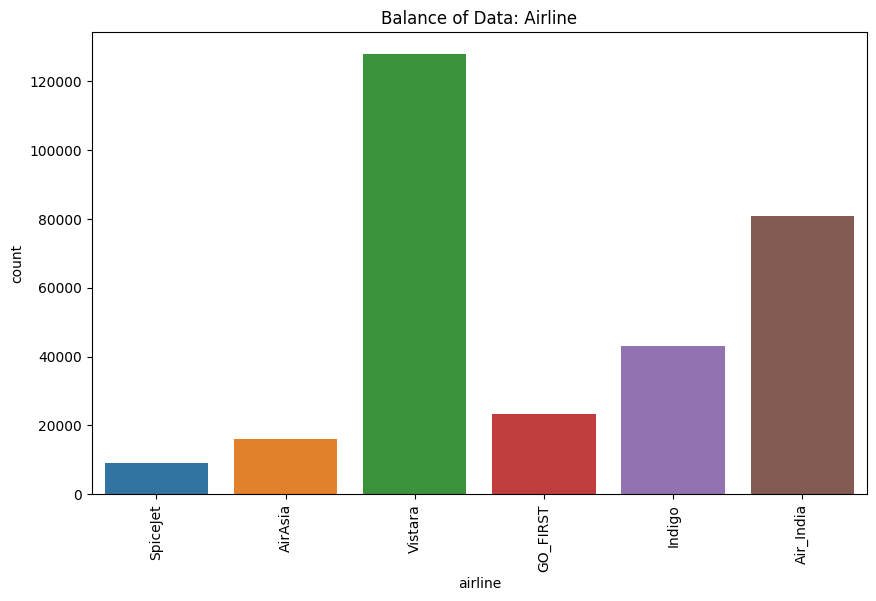

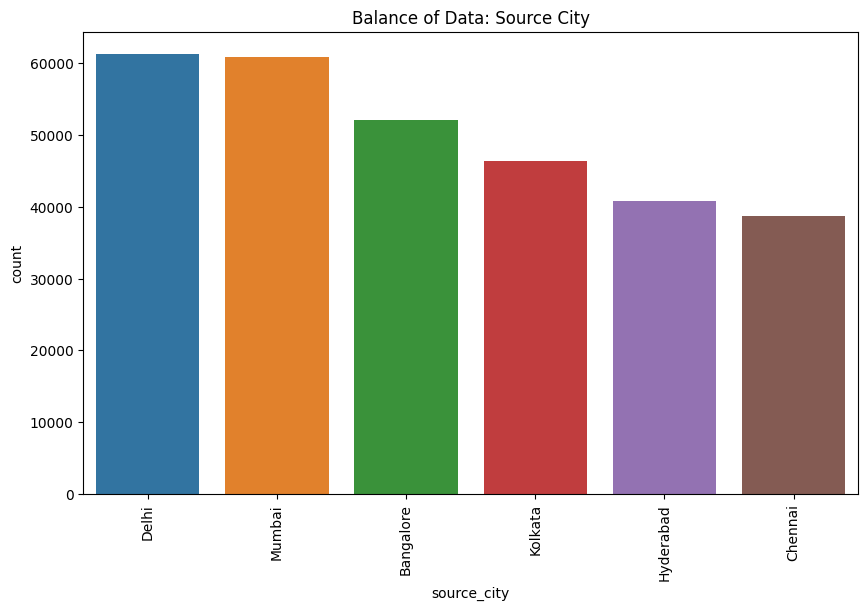

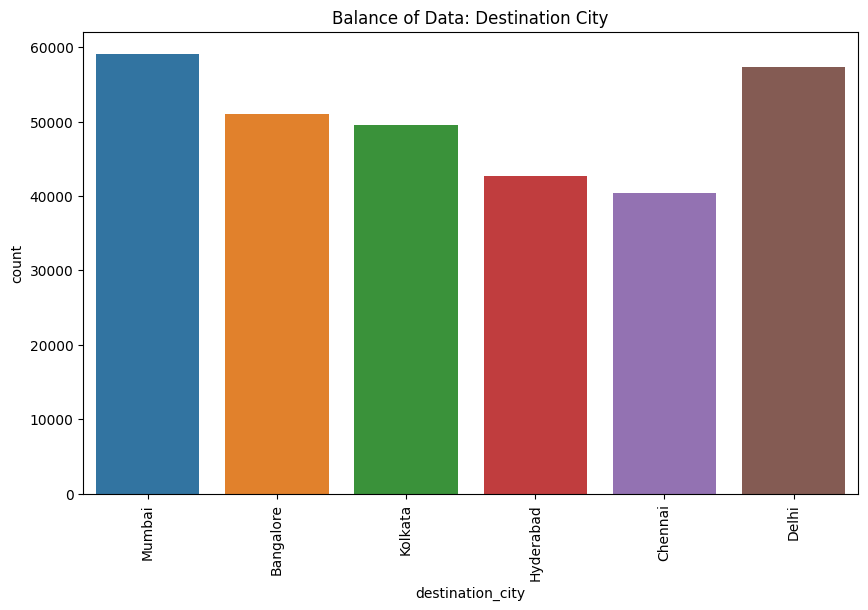

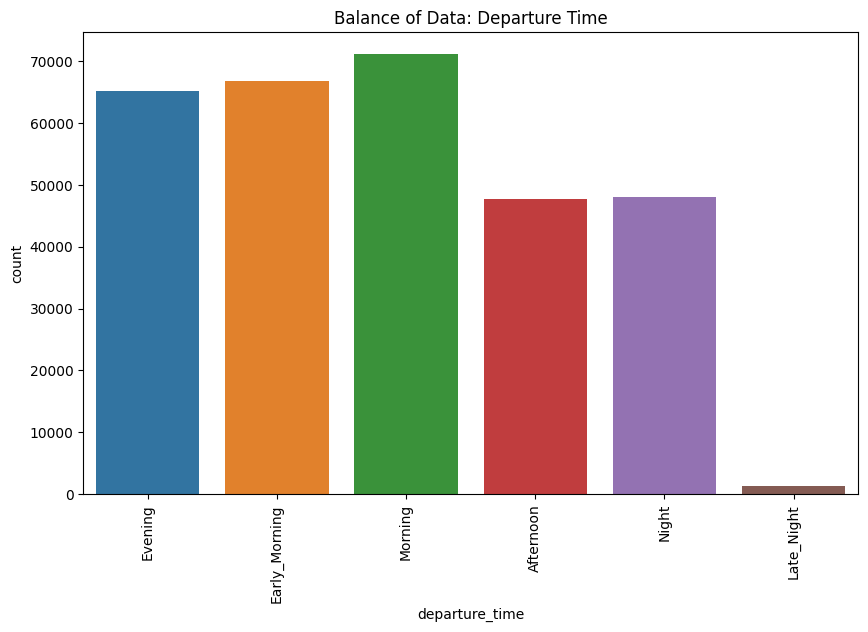

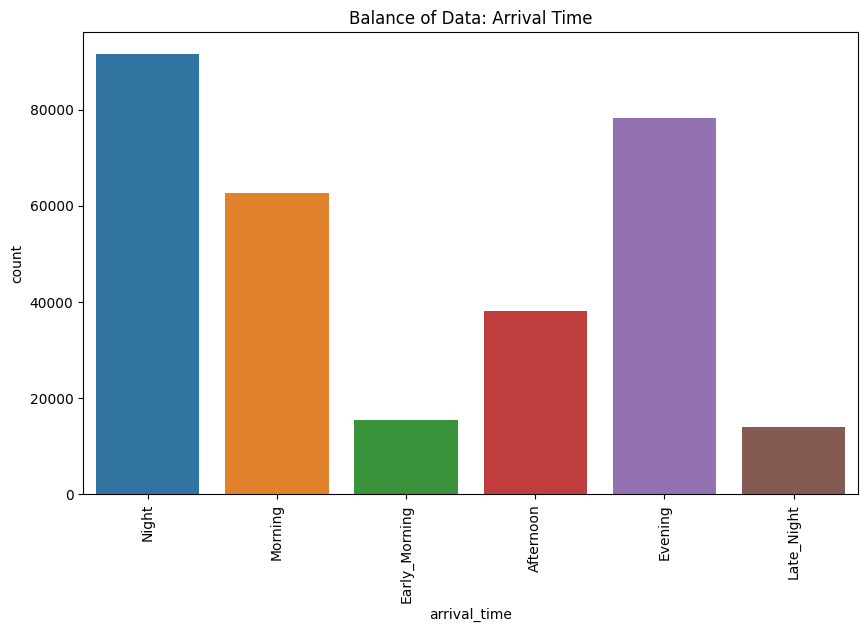

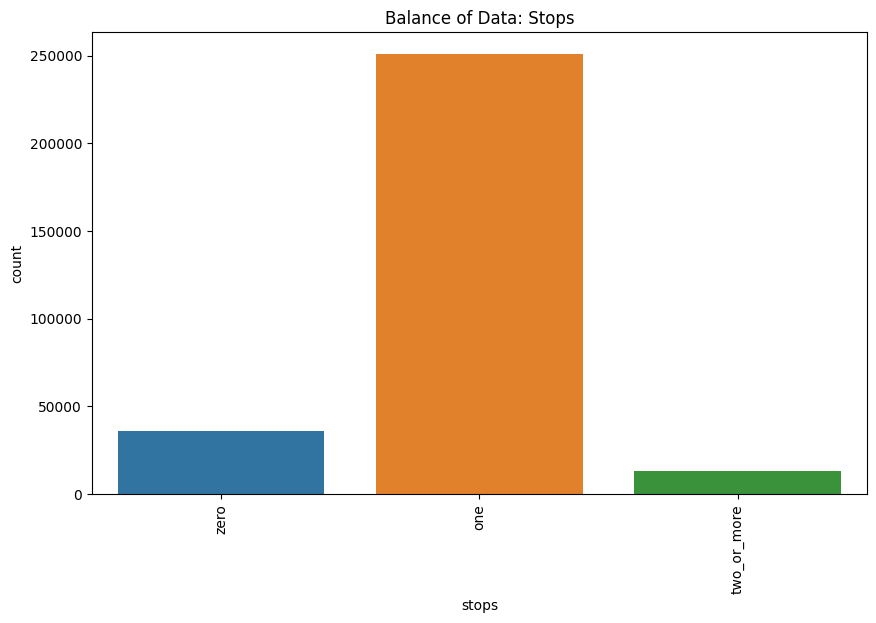

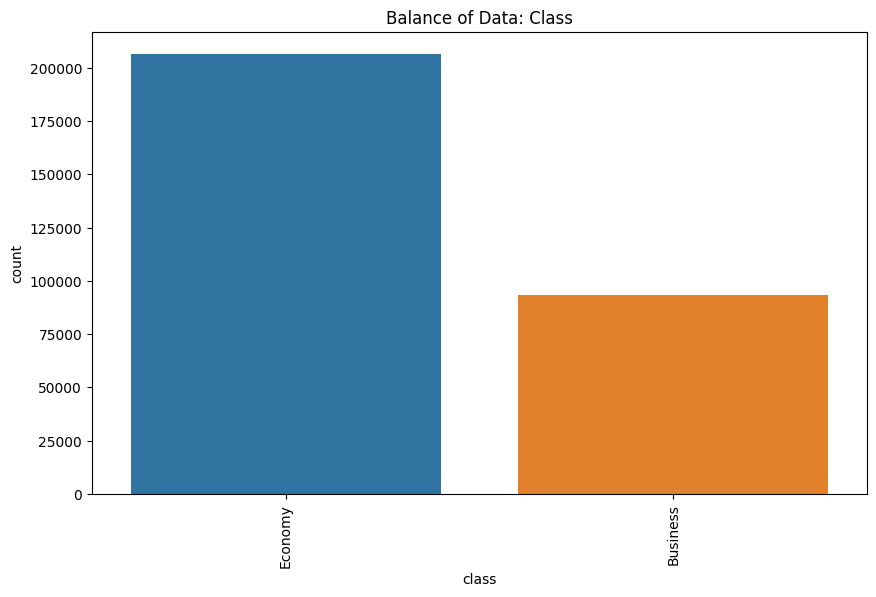

In [7]:
def visualize_balance(data, column, title=''):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=data)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Visualize the balance of data for different categorical features
visualize_balance(df, 'airline', 'Balance of Data: Airline')
visualize_balance(df, 'source_city', 'Balance of Data: Source City')
visualize_balance(df, 'destination_city', 'Balance of Data: Destination City')
visualize_balance(df, 'departure_time', 'Balance of Data: Departure Time')
visualize_balance(df, 'arrival_time', 'Balance of Data: Arrival Time')
visualize_balance(df, 'stops', 'Balance of Data: Stops')
visualize_balance(df, 'class', 'Balance of Data: Class')

In [8]:
columns_to_label_encode = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class','flight']
label_encoders = {}
for column in columns_to_label_encode:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    label_encoders[column] = label_encoder

In [9]:
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
model = lgb.LGBMRegressor()
model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 11
[LightGBM] [Info] Start training from score 20888.572417


LGBMRegressor()

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': 'r2'
}

cv_results = cross_validate(model, X_scaled, y, cv=kfold, scoring=scoring, return_train_score=True)


print(f'Mean Squared Error (MSE) on test set: {cv_results["test_mse"].mean()}')
print(f'R-squared (R²) on test set: {cv_results["test_r2"].mean()}')


print(f'Mean Squared Error (MSE) on train set: {cv_results["train_mse"].mean()}')
print(f'R-squared (R²) on train set: {cv_results["train_r2"].mean()}')


print("Fold-wise MSE on test set:", cv_results["test_mse"])
print("Fold-wise R² on test set:", cv_results["test_r2"])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 270137, number of used features: 11
[LightGBM] [Info] Start training from score 20893.986022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 270137, number of used features: 11
[LightGBM] [Info] Start training from score 20884.395085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 270137, number of used features: 11
[LightGBM] [Info] S